# About

This notebook focuses on using actuarial methods to explore claims data. i.e. mainly interested in any particular trends based on accident years and any abnormal data. Data from Kaggle competition (closed 2 years before my starting this exploration and work, what a shame!):

https://www.kaggle.com/competitions/actuarial-loss-estimation/overview

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, TweedieRegressor
from sklearn.preprocessing import KBinsDiscretizer
from sklearn import preprocessing
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

In [2]:
df = pd.read_csv('train.csv')
df_submit_test = pd.read_csv('test.csv')

df = df.rename(columns={'InitialIncurredCalimsCost': 'InitialClaim', 'UltimateIncurredClaimCost': 'UltimateClaim'}, errors="raise")
df_submit_test = df_submit_test.rename(columns={'InitialIncurredCalimsCost': 'InitialClaim'}, errors="raise")

for dset in [df, df_submit_test]:
    dset['DateTimeOfAccident'] = pd.to_datetime(dset['DateTimeOfAccident'], format='%Y-%m-%dT%H:%M:%SZ')
    dset['DateReported'] = pd.to_datetime(dset['DateReported'], format='%Y-%m-%dT%H:%M:%SZ')
    dset['DateAcc'] = dset['DateTimeOfAccident'].dt.date
    dset['AccYear'] = dset['DateTimeOfAccident'].dt.year
    dset['AccMonth'] = dset['DateTimeOfAccident'].dt.month
    dset['AccWeekDay'] = dset['DateTimeOfAccident'].dt.weekday
    dset['AccHour'] = dset['DateTimeOfAccident'].dt.hour
    dset['time_lag'] = (dset['DateReported'].dt.date - dset['DateAcc'])/ np.timedelta64(1, 'D')
    dset['Initial/Wage'] = dset['InitialClaim'] / dset['WeeklyWages']

In [3]:
df.describe()

,DateTimeOfAccident,DateReported,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,InitialClaim,UltimateClaim,AccYear,AccMonth,AccWeekDay,AccHour,time_lag,Initial/Wage
count,54000,54000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,5.400000e+04,5.400000e+04,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000
mean,1997-01-03 05:08:31.666666752,1997-02-11 01:00:17.600000,33.842370,0.119185,0.009944,416.364807,37.735084,4.905759,7.841146e+03,1.100337e+04,1996.508389,6.509870,2.296593,11.577685,39.310019,60.175754
min,1988-01-01 09:00:00,1988-01-08 00:00:00,13.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,1.218868e+02,1988.000000,1.000000,0.000000,0.000000,0.000000,0.000984
25%,1992-06-30 07:00:00,1992-08-04 00:00:00,23.000000,0.000000,0.000000,200.000000,38.000000,5.000000,7.000000e+02,9.263384e+02,1992.000000,4.000000,1.000000,9.000000,14.000000,2.100000
50%,1997-01-07 10:00:00,1997-02-16 00:00:00,32.000000,0.000000,0.000000,392.200000,38.000000,5.000000,2.000000e+03,3.371242e+03,1997.000000,7.000000,2.000000,11.000000,22.000000,5.833333
75%,2001-07-09 11:00:00,2001-08-25 00:00:00,43.000000,0.000000,0.000000,500.000000,40.000000,5.000000,9.500000e+03,8.197249e+03,2001.000000,9.000000,4.000000,14.000000,41.000000,21.107528
max,2005-12-31 10:00:00,2006-09-23 00:00:00,81.000000,9.000000,5.000000,7497.000000,640.000000,7.000000,2.000000e+06,4.027136e+06,2005.000000,12.000000,6.000000,23.000000,1095.000000,690000.000000
std,NaN,NaN,12.122165,0.517780,0.109348,248.638669,12.568704,0.552129,2.058408e+04,3.339099e+04,5.188254,3.401477,1.704768,3.751218,61.108097,3145.609037


In [4]:
df_submit_test.describe()

,DateTimeOfAccident,DateReported,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,InitialClaim,AccYear,AccMonth,AccWeekDay,AccHour,time_lag,Initial/Wage
count,36000,36000,36000.000000,36000.000000,36000.000000,36000.00000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000
mean,1996-12-26 03:22:20.200000,1997-02-02 10:13:55.200000,33.856556,0.120000,0.009611,416.37745,37.758841,4.912417,7679.306889,1996.487417,6.499139,2.288861,11.563611,38.767639,45.363319
min,1988-01-01 06:00:00,1988-01-13 00:00:00,13.000000,0.000000,0.000000,1.00000,0.000000,1.000000,1.000000,1988.000000,1.000000,0.000000,0.000000,0.000000,0.000855
25%,1992-06-15 10:00:00,1992-07-16 18:00:00,23.000000,0.000000,0.000000,200.00000,38.000000,5.000000,650.000000,1992.000000,4.000000,1.000000,9.000000,14.000000,2.033029
50%,1996-12-19 14:30:00,1997-02-04 12:00:00,32.000000,0.000000,0.000000,395.18500,38.000000,5.000000,2000.000000,1996.000000,7.000000,2.000000,11.000000,23.000000,5.755883
75%,2001-06-16 06:30:00,2001-08-02 00:00:00,43.000000,0.000000,0.000000,500.00000,40.000000,5.000000,9500.000000,2001.000000,10.000000,4.000000,14.000000,41.000000,20.938298
max,2005-12-29 14:00:00,2007-01-07 00:00:00,80.000000,8.000000,5.000000,7400.00000,700.000000,7.000000,725000.000000,2005.000000,12.000000,6.000000,23.000000,1089.000000,46000.000000
std,NaN,NaN,12.124416,0.522437,0.108357,242.49109,11.951296,0.540451,17501.991600,5.188056,3.403999,1.698185,3.732404,57.764673,640.166729


# Outlier

The outlier (see below) was detected previously.

In [5]:
df=df.drop(df.index[11027])

Let's also explore abnormal data in the low extreme end:

In [6]:
df.nlargest(50, 'UltimateClaim')

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,...,ClaimDescription,InitialClaim,UltimateClaim,DateAcc,AccYear,AccMonth,AccWeekDay,AccHour,time_lag,Initial/Wage
23036,WC4540054,1994-09-22 20:00:00,1994-11-29,37,M,M,0,0,200.00,F,...,WHILST MASSAGING FELT PAIN SOFT TISSUE INJURY ...,7500,865770.6486,1994-09-22,1994,9,3,20,68.0,37.500000
37813,WC2854573,1990-03-12 17:00:00,1990-03-21,55,F,M,2,0,474.38,F,...,TABLE TIPPED OVER SOFT TISSUE INJURY RIGHT HAND,7500,823706.3012,1990-03-12,1990,3,0,17,9.0,15.810110
3193,WC8981820,2003-02-27 10:00:00,2003-03-29,40,M,S,0,0,523.47,F,...,LIFTING BACK BACK STRAIN,17880,768485.1182,2003-02-27,2003,2,3,10,30.0,34.156685
923,WC9097605,2004-06-25 14:00:00,2004-08-23,27,M,U,0,0,801.54,F,...,SHEARING HAND PIECE BLISTER RIGHT HAND,40456,742003.2335,2004-06-25,2004,6,4,14,59.0,50.472840
47532,WC9789765,2005-10-27 14:00:00,2005-11-12,51,F,M,0,0,500.00,F,...,LIFTING PARTS STRAIN BACK LOWER BACK STRAIN,20000,741498.0275,2005-10-27,2005,10,3,14,16.0,40.000000
28959,WC7286241,2000-09-23 09:00:00,2000-11-05,46,M,M,3,1,1183.00,F,...,LIFTING BOX FROM TOOL BOX HERNIA,250000,713784.0636,2000-09-23,2000,9,5,9,43.0,211.327134
25148,WC7977652,2001-03-20 12:00:00,2001-06-15,39,M,M,0,0,200.00,F,...,LIFTING DRUM LOWER BACK PAIN,30000,608650.4259,2001-03-20,2001,3,1,12,87.0,150.000000
3588,WC9540190,2005-12-16 08:00:00,2005-12-26,39,M,M,0,0,607.08,F,...,LIFTING KEGS LOWER BACK SOFT TISSUE INJURY LOW...,9500,586912.8191,2005-12-16,2005,12,4,8,10.0,15.648679
1811,WC9879169,2005-07-09 16:00:00,2006-06-10,55,F,S,0,0,1522.70,F,...,CAUGHT BETWEEN DOOR FRAME GRAZE HEAD,119686,558408.9616,2005-07-09,2005,7,5,16,336.0,78.601169
23533,WC8185246,2002-11-24 09:00:00,2002-12-14,21,M,S,0,0,300.12,P,...,SCRAPER SLIPPED AND HIT HEAD HYPERFLEXION INJU...,5000,536763.4713,2002-11-24,2002,11,6,9,20.0,16.660003


Let's see abnormal points on the smallest side, this time focusing on initial claim instead.

In [7]:
df.nsmallest(50, 'InitialClaim')

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,...,ClaimDescription,InitialClaim,UltimateClaim,DateAcc,AccYear,AccMonth,AccWeekDay,AccHour,time_lag,Initial/Wage
723,WC8356908,2002-11-11 14:00:00,2004-01-12,24,M,U,1,0,200.00,F,...,STRUCK PIECE STEEL LACERATION LEFT MIDDLE FINGER,1,874.156958,2002-11-11,2002,11,0,14,427.0,0.005000
2522,WC8294905,2002-11-27 13:00:00,2003-01-24,39,M,U,0,0,500.00,F,...,WALKED INTO BOAT AERIAL LACERATION RIGHT HAND,1,785.401266,2002-11-27,2002,11,2,13,58.0,0.002000
3119,WC8794597,2003-04-16 10:00:00,2003-05-01,30,M,M,0,0,500.00,F,...,LIFTING TUB LOWER BACK STRAIN,1,2762.305732,2003-04-16,2003,4,2,10,15.0,0.002000
5231,WC9057923,2003-01-21 09:00:00,2003-02-13,23,F,U,0,0,431.70,F,...,PARTICLE FROM GRINDER FOREIGN BODY EYE,1,768.002916,2003-01-21,2003,1,1,9,23.0,0.002316
5647,WC8353097,2002-12-20 19:00:00,2003-02-17,17,M,U,0,0,200.00,F,...,STRUCK HOSE FRACTURED FRONT TOOTH,1,2184.550765,2002-12-20,2002,12,4,19,59.0,0.005000
9572,WC8939733,2003-04-09 09:00:00,2003-04-24,55,M,U,0,0,514.15,F,...,FINGER CAUGHT ON DOOR FRAME LACERATION LEFT IN...,1,1395.692887,2003-04-09,2003,4,2,9,15.0,0.001945
10144,WC9050708,2003-02-14 10:00:00,2003-02-24,29,M,U,0,0,221.60,F,...,MOVING STEEL TROLLEY STRAIN LOW BACK PAIN,1,6030.333056,2003-02-14,2003,2,4,10,10.0,0.004513
11289,WC8932396,2003-04-16 11:00:00,2003-05-01,30,F,U,0,0,410.67,F,...,STRUCK KNIFE LACERATED MIDDLE FINGER,1,865.737643,2003-04-16,2003,4,2,11,15.0,0.002435
12175,WC8965152,2003-04-01 10:00:00,2003-04-24,40,F,U,0,0,500.00,P,...,CAUGHT BETWEEN STEEL ROD LACERATION RIGHT INDE...,1,1206.978245,2003-04-01,2003,4,1,10,23.0,0.002000
12479,WC8970295,2003-02-27 12:00:00,2003-03-12,41,M,U,0,0,782.60,F,...,RECURRING PREVIOUS INJURY PAIN LEFT KNEE,1,5116.281649,2003-02-27,2003,2,3,12,13.0,0.001278


Interestingly, those initial claims of 1 dollar are mostly around the years 2002-2003. This might be the bad practice of a claim handler employed during the period. Other interesting point is some precise but abnormally small claim amount e.g. 9 dollars, which 'might' be used for administrative purpose to identify certain type of claims when IT system was not yet upgraded - but this cannot be verified in this setting. One practical approach might be to correct these data to be 100 at least. (the smallest ultimate claim is roughly 100)

## Development factors

Although loss development factors at different stages cannot be calculated as only initial claims and utlimate claims are provided, we can work out development factor at initial stage (focus on IBNER only instead of both IBNER and IBNYR, for the purpose of this task). Let's investigate the data first.

In [8]:
def development(df, extreme=1e+15, metric='UltimateClaim'):
    table_dev = np.round(pd.pivot_table(df[df[metric]<extreme], 
        values=['time_lag', 'WeeklyWages', 'Initial/Wage', 'InitialClaim', 'UltimateClaim'], 
        index=['AccYear'], aggfunc={np.mean}))
    table_dev['dev_factor']= np.round(table_dev[('UltimateClaim', 'mean')]/table_dev[('InitialClaim', 'mean')],3)
    table_dev['injury_factor']= np.round(table_dev[('UltimateClaim', 'mean')]/table_dev[('WeeklyWages', 'mean')],1)
    return table_dev

In [9]:
table_dev = development(df)
table_dev

,Initial/Wage,InitialClaim,UltimateClaim,WeeklyWages,time_lag,dev_factor,injury_factor
,mean,mean,mean,mean,mean,,
AccYear,,,,,,,
1988,11.0,3542.0,6273.0,357.0,36.0,1.771,17.6
1989,10.0,3128.0,6331.0,359.0,37.0,2.024,17.6
1990,20.0,2667.0,5542.0,353.0,38.0,2.078,15.7
1991,26.0,3063.0,6292.0,389.0,35.0,2.054,16.2
1992,11.0,3720.0,7285.0,401.0,36.0,1.958,18.2
1993,14.0,4810.0,7737.0,407.0,35.0,1.609,19.0
1994,41.0,5525.0,7847.0,400.0,37.0,1.420,19.6
1995,51.0,4394.0,5959.0,338.0,42.0,1.356,17.6


In [10]:
table_dev.to_csv('dev_factor.csv', encoding='utf-8')

In [11]:
table_dev_300k = development(df, 300000)
table_dev_300k

,Initial/Wage,InitialClaim,UltimateClaim,WeeklyWages,time_lag,dev_factor,injury_factor
,mean,mean,mean,mean,mean,,
AccYear,,,,,,,
1988,11.0,3542.0,6273.0,357.0,36.0,1.771,17.6
1989,10.0,3123.0,6098.0,359.0,37.0,1.953,17.0
1990,20.0,2665.0,5267.0,353.0,38.0,1.976,14.9
1991,26.0,3054.0,5920.0,389.0,35.0,1.938,15.2
1992,10.0,3597.0,6748.0,401.0,36.0,1.876,16.8
1993,14.0,4812.0,7625.0,407.0,35.0,1.585,18.7
1994,41.0,5525.0,7559.0,400.0,37.0,1.368,18.9
1995,51.0,4393.0,5750.0,338.0,42.0,1.309,17.0


In [12]:
table_dev_200k = development(df, 200000)
table_dev_100k = development(df, 100000)
table_dev_50k = development(df, 50000)
table_dev_10k = development(df, 10000)

Note: 10k is roughly the mean of actual ultimate claim, while 200k is roughly the largest prediction of exisitng models so far.

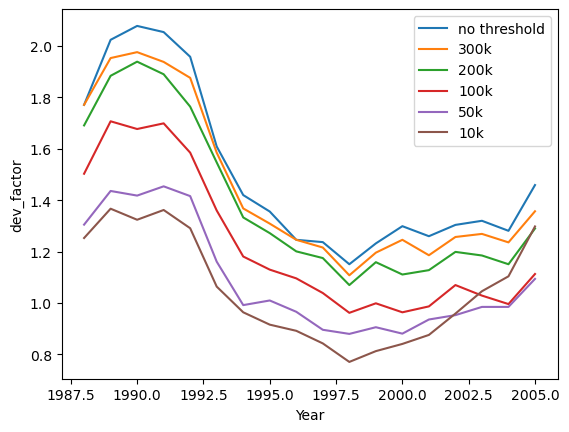

In [13]:
plt.plot(table_dev['dev_factor'], label = 'no threshold')
plt.plot(table_dev_300k['dev_factor'], label = '300k')
plt.plot(table_dev_200k['dev_factor'], label = '200k')
plt.plot(table_dev_100k['dev_factor'], label = '100k')
plt.plot(table_dev_50k['dev_factor'], label = '50k')
plt.plot(table_dev_10k['dev_factor'], label = '10k')
plt.xlabel('Year')
plt.ylabel('dev_factor')
plt.legend()
plt.show()

# Insights 

1. The development factors have clear trend instead of just fluctuating. Possibly due to claims management practice/focus e.g. focusing on bringing down underestimation during the first ~10 years, while avoiding reserving too much initially during the second ~10 years.
2. As development factors have clear trend, we may better use different development factors for different years for predictive model components. (Also because the testing data with ultimate claims masked have similar trend for other monetary amounts and roughly similar demographic profile.)
3. Dropping the threshold down to 100k, the curves retain roughly the same shape but shift downwards. This implies that ultimate claims above 100k are usually more underestimated initially.
4. Curves with threshold 50k and 10k: development factors dropped to below 1 around the middle of the period. Perhaps it triggers the claims management team to reverse the strategy of claims reserving.
5. When the threshold drops further to 50k and 10k, the development factors are decreasing slower or even increasing during the last few years. This implies claims within these range are overestimated by claims handlers in the last few years. This may also imply threshold should ideally be larger for recent years but smaller for old years to differentiate different behaviours.

## Claims Distribution

Let's see how claims are distributed overall, and then split by years.

In [14]:
Ult_year_sort = df[['UltimateClaim', 'AccYear']].sort_values(by='UltimateClaim')

<Axes: ylabel='Ultimate Claim'>

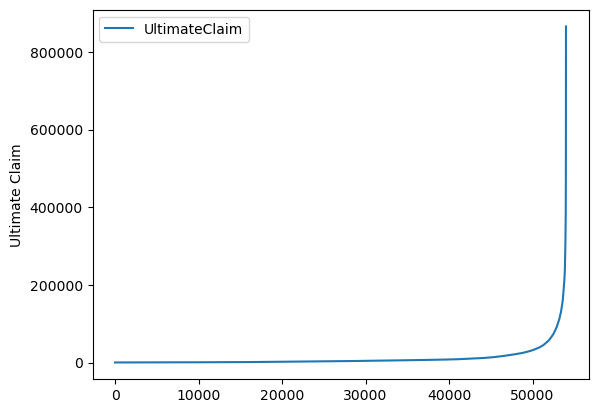

In [15]:
Ult_year_sort.plot(y='UltimateClaim', use_index=False, ylabel='Ultimate Claim', xlabel='Count index')

The graph shows clearly that most claims are below the threshold 100k or even 50k.

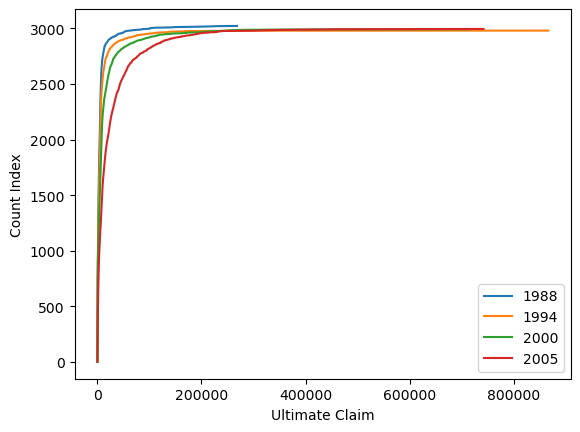

In [16]:
for yr in [1988, 1994, 2000, 2005]:
    x = Ult_year_sort[Ult_year_sort['AccYear']==yr].UltimateClaim
    plt.plot(x, [i for i in range(len(x))], label = yr)
plt.xlabel('Ultimate Claim')
plt.ylabel('Count Index')
plt.legend()
plt.show()

By interchanging the axis and split by years, we have a graph analogous to cumulative distribution, which looks like exponential distribution, a member of gamma distribution. Gamma distribution is widely used by actuaries modelling claims.

This graph confirms ultimate claims have similar distribution across years, but with claims inflation. 

See below for the histogram (analogous to density distribution) of all ultimate claims. It also looks like exponential distribution.

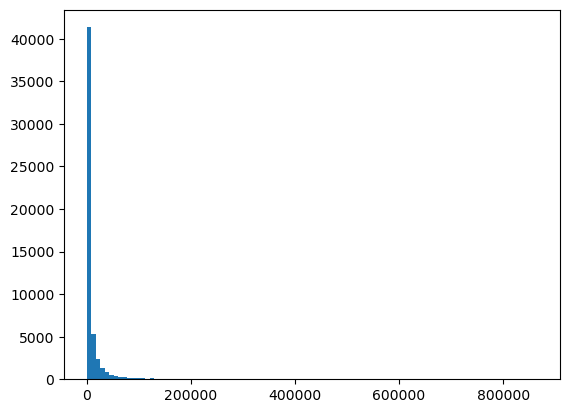

In [17]:
plt.hist(Ult_year_sort.UltimateClaim, bins=100)
plt.show()

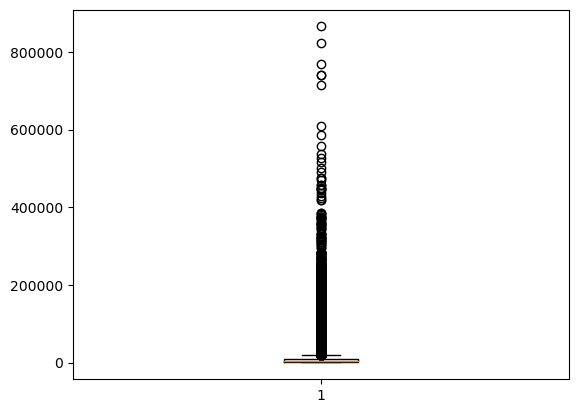

In [18]:
plt.boxplot(df.UltimateClaim)
plt.show()

In [96]:
print('Percentiles of Claims:')
print('qth Ultimate Initial')
for q in range(0, 20):
    print(q, '  ', round(np.percentile(df.UltimateClaim, q)), '  ', round(np.percentile(df.InitialClaim, q)))

Percentiles of Claims:
qth Ultimate Initial
0    122    1
1    208    160
2    239    200
3    262    250
4    284    300
5    307    315
6    329    350
7    351    400
8    375    420
9    400    475
10    424    500
11    448    500
12    472    500
13    499    500
14    526    500
15    554    500
16    584    500
17    615    500
18    646    500
19    680    500


In [20]:
print('Percentiles of Claims:')
print('qth Ultimate Initial')
for q in range(0, 100, 10):
    print(q, '  ', round(np.percentile(df.UltimateClaim, q)), '  ', round(np.percentile(df.InitialClaim, q)))

Percentiles of Claims:
qth Ultimate Initial
0    122    1
10    424    500
20    717    500
30    1210    950
40    1980    1260
50    3371    2000
60    5113    3500
70    6915    7500
80    10437    10000
90    24004    18500


In [21]:
print('Percentiles of Claims:')
print('qth Ultimate Initial')
for q in range(91, 100):
    print(q, '  ', round(np.percentile(df.UltimateClaim, q)), '  ', round(np.percentile(df.InitialClaim, q)))

Percentiles of Claims:
qth Ultimate Initial
91    26542    20000
92    29711    23000
93    33516    25000
94    38385    26000
95    45206    30000
96    54958    37000
97    69884    45000
98    93497    53500
99    138910    75000


In [22]:
unique_values = df.InitialClaim.unique()

In [95]:
value_freq={}
for i in unique_values:
    value_freq[i] = np.count_nonzero(df.InitialClaim == i)
sorted_value_freq = dict(sorted(value_freq.items(), key=lambda x:x[1])) 
for value in sorted_value_freq:
    if value_freq[value]>=200:
        print(value, ':', value_freq[value])

4500 : 201
1600 : 211
1400 : 252
1200 : 253
420 : 255
11000 : 274
7000 : 275
630 : 278
650 : 279
30000 : 280
50000 : 284
750 : 291
550 : 306
900 : 307
6000 : 330
8000 : 333
250 : 340
1300 : 386
350 : 428
200 : 469
4000 : 531
20000 : 547
3000 : 576
12000 : 620
700 : 622
600 : 645
400 : 676
800 : 680
2500 : 770
300 : 771
15000 : 816
25000 : 831
5000 : 928
9500 : 1255
2000 : 1607
1500 : 2329
7500 : 2507
3500 : 2600
10000 : 3453
1000 : 4587
500 : 6260


In [131]:
df['ClaimGroup'] = pd.cut(df.InitialClaim, [1, 499, 500, 1000, 2000, 4000, 8000, 10000, 20000, 100000, 1000000], right=True)

In [101]:
df['InitialAdjust'] = df.InitialClaim.apply(lambda x: max(x, 100))

In [107]:
df['dev_adjust'] = df['UltimateClaim']/df['InitialAdjust']

In [106]:
claim_group = np.round(pd.pivot_table(df, 
        values=['InitialClaim', 'InitialAdjust', 'UltimateClaim'], 
        index=['ClaimGroup'], aggfunc={np.count_nonzero, np.sum}))
claim_group

InitialAdjust             InitialClaim             \
                  count_nonzero        sum count_nonzero        sum   
ClaimGroup                                                            
(1, 499]                   4847    1454290          4847    1452634   
(499, 500]                 6260    3130000          6260    3130000   
(500, 1000]                9722    8215415          9722    8215415   
(1000, 2000]               6574   10496399          6574   10496399   
(2000, 4000]               6260   19994036          6260   19994036   
(4000, 8000]               5966   38897690          5966   38897690   
(8000, 10000]              5258   51338855          5258   51338855   
(10000, 20000]             4383   64903945          4383   64903945   
(20000, 100000]            4401  173821798          4401  173821798   
(100000, 1000000]           281   49128067           281   49128067   

                  UltimateClaim               
                  count_nonzero          sum  
ClaimGroup                                    
(1, 499]                   4847    5287050.0  
(499, 500]                 6260    7726778.0  
(500, 1000]                9722   18716024.0  
(1000, 2000]               6574   28316979.0  
(2000, 4000]               6260   51424318.0  
(4000, 8000]               5966   62999170.0  
(8000, 10000]              5258   65331989.0  
(10000, 20000]             4383  106700022.0  
(20000, 100000]            4401  209008232.0  
(100000, 1000000]           281   34410125.0

In [118]:
df['DevGroup'] = pd.cut(df.dev_adjust, [0.04, 0.1, 0.25, 0.4, 0.5, 0.75, 1, 1.5, 2, 3, 4, 5, 10, 20, 100, 830], right=True)

In [119]:
dev_group = np.round(pd.pivot_table(df, 
        values=['InitialAdjust', 'UltimateClaim', 'dev_adjust', ], 
        index=['DevGroup'], aggfunc={np.count_nonzero, np.sum}))
dev_group

InitialAdjust            UltimateClaim              \
               count_nonzero        sum count_nonzero         sum   
DevGroup                                                            
(0.04, 0.1]                3    3415000             3    186934.0   
(0.1, 0.25]               17    6185411            17    986316.0   
(0.25, 0.4]              626   12442570           626   4297795.0   
(0.4, 0.5]              2085   27417461          2085  12460508.0   
(0.5, 0.75]            10687  111356208         10687  70391057.0   
(0.75, 1.0]            11444  102730923         11444  88790846.0   
(1.0, 1.5]             11601   81238345         11601  97552365.0   
(1.5, 2.0]              5961   28726780          5961  49352032.0   
(2.0, 3.0]              5213   21902314          5213  52738700.0   
(3.0, 4.0]              2240    9469670          2240  32851589.0   
(4.0, 5.0]              1147    5636488          1147  25103064.0   
(5.0, 10.0]             1749    8449731          1749  57830771.0   
(10.0, 20.0]             654    2939534           654  39644633.0   
(20.0, 100.0]            497    1403147           497  46939992.0   
(100.0, 830.0]            75      71513            75  11028198.0   

                  dev_adjust           
               count_nonzero      sum  
DevGroup                               
(0.04, 0.1]                3      0.0  
(0.1, 0.25]               17      3.0  
(0.25, 0.4]              626    224.0  
(0.4, 0.5]              2085    954.0  
(0.5, 0.75]            10687   6778.0  
(0.75, 1.0]            11444   9954.0  
(1.0, 1.5]             11601  14078.0  
(1.5, 2.0]              5961  10297.0  
(2.0, 3.0]              5213  12585.0  
(3.0, 4.0]              2240   7713.0  
(4.0, 5.0]              1147   5096.0  
(5.0, 10.0]             1749  11817.0  
(10.0, 20.0]             654   9038.0  
(20.0, 100.0]            497  20016.0  
(100.0, 830.0]            75  14644.0

In [130]:
dev_claim_mark = np.round(pd.pivot_table(df, 
        values=['InitialClaim'], columns=['ClaimGroup'],
        index=['DevGroup'], aggfunc={np.count_nonzero}, fill_value=0))
dev_claim_mark

InitialClaim                                                   \
               count_nonzero                                                    
ClaimGroup          (1, 499] (499, 500] (500, 1000] (1000, 2000] (2000, 4000]   
DevGroup                                                                        
(0.04, 0.1]                0          0           0            0            0   
(0.1, 0.25]                0          0           0            0            0   
(0.25, 0.4]                3        124         108           17           14   
(0.4, 0.5]                57        387         402           69           60   
(0.5, 0.75]              528       1498        1849          787          563   
(0.75, 1.0]              675       1027        1761         1249          862   
(1.0, 1.5]              1077       1121        1928         1617         1620   
(1.5, 2.0]               621        553        1084         1011         1604   
(2.0, 3.0]               696        682        1288          935          894   
(3.0, 4.0]               372        344         580          390          213   
(4.0, 5.0]               220        192         242          157           78   
(5.0, 10.0]              373        239         324          158          137   
(10.0, 20.0]             148         40          61           72           94   
(20.0, 100.0]             52         34          78          104          118   
(100.0, 830.0]            25         19          17            8            3   

                                                                          \
                                                                           
ClaimGroup     (4000, 8000] (8000, 10000] (10000, 20000] (20000, 100000]   
DevGroup                                                                   
(0.04, 0.1]               0             0              0               0   
(0.1, 0.25]               0             3              0               0   
(0.25, 0.4]              91           157             23              46   
(0.4, 0.5]              278           481             92             213   
(0.5, 0.75]            1478          1783            815            1314   
(0.75, 1.0]            1680          1580           1321            1256   
(1.0, 1.5]             1410           729           1286             766   
(1.5, 2.0]              403           144            253             277   
(2.0, 3.0]              196           109            177             225   
(3.0, 4.0]               77            39            102             121   
(4.0, 5.0]               64            33             77              83   
(5.0, 10.0]             147           117            158              88   
(10.0, 20.0]             99            56             64              11   
(20.0, 100.0]            40            27             15               1   
(100.0, 830.0]            3             0              0               0   

                                  
                                  
ClaimGroup     (100000, 1000000]  
DevGroup                          
(0.04, 0.1]                    2  
(0.1, 0.25]                   14  
(0.25, 0.4]                   43  
(0.4, 0.5]                    46  
(0.5, 0.75]                   72  
(0.75, 1.0]                   33  
(1.0, 1.5]                    47  
(1.5, 2.0]                    11  
(2.0, 3.0]                    10  
(3.0, 4.0]                     2  
(4.0, 5.0]                     1  
(5.0, 10.0]                    0  
(10.0, 20.0]                   0  
(20.0, 100.0]                  0  
(100.0, 830.0]                 0

In [133]:
dev_claim_mark = np.round(pd.pivot_table(df, 
        values=['InitialClaim'], columns=['AccYear'],
        index=['DevGroup'], aggfunc={np.count_nonzero}, fill_value=0))
dev_claim_mark

InitialClaim                                               \
               count_nonzero                                                
AccYear                 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997   
DevGroup                                                                    
(0.04, 0.1]                0    0    0    0    0    0    0    1    0    0   
(0.1, 0.25]                1    0    1    0    1    0    0    0    1    0   
(0.25, 0.4]               13   11   12    7   10   23   23   39   68   83   
(0.4, 0.5]                53   44   52   51   48   59   77  145  191  196   
(0.5, 0.75]              358  358  402  350  383  513  585  644  796  813   
(0.75, 1.0]              542  492  543  504  523  631  743  661  640  644   
(1.0, 1.5]               724  667  694  711  699  672  676  622  558  587   
(1.5, 2.0]               494  527  441  515  477  375  303  302  263  234   
(2.0, 3.0]               379  397  396  403  433  352  254  257  244  214   
(3.0, 4.0]               158  177  152  146  145  127  117  117   96   88   
(4.0, 5.0]                78   82   84   85   82   57   53   46   44   52   
(5.0, 10.0]              139  115  109  112  113  116   88   91   79   64   
(10.0, 20.0]              48   51   46   39   60   37   40   30   27   29   
(20.0, 100.0]             31   49   32   42   42   36   16   25   24   23   
(100.0, 830.0]             5    7    7    8    6    5    6    3    3    4   

                                                        
                                                        
AccYear        1998 1999 2000 2001 2002 2003 2004 2005  
DevGroup                                                
(0.04, 0.1]       0    0    1    0    0    0    1    0  
(0.1, 0.25]       3    1    0    2    2    2    2    1  
(0.25, 0.4]     100   66   40   33   27   35   25   11  
(0.4, 0.5]      253  217  185  131  138  127   80   38  
(0.5, 0.75]     819  846  841  718  662  614  562  423  
(0.75, 1.0]     587  620  695  747  784  749  738  601  
(1.0, 1.5]      491  515  530  625  637  631  721  841  
(1.5, 2.0]      246  232  222  222  235  240  268  365  
(2.0, 3.0]      201  217  189  244  250  244  263  276  
(3.0, 4.0]       99   92   81  103  103  121  149  169  
(4.0, 5.0]       43   47   69   62   39   61   76   87  
(5.0, 10.0]      77   89   87   93   73   77   89  138  
(10.0, 20.0]     28   33   31   33   25   37   36   24  
(20.0, 100.0]    13   19   20   14   30   39   21   21  
(100.0, 830.0]    4    5    2    1    6    1    1    1

## Report time and time lag

Report time and time lag reflect the stage of development factor for the initial claim reserving, especially in this setting, where no intermediate reserving and payment data are provided.

Legally, bodily injury claims must be reported within 3 years, i.e. 1095 days, though the exact jurisdiction was not revealed.  No records have exceeded this threshold, though the max time lag of each dataset is at or near the threshold.

In [23]:
time_lag_sort = df[['time_lag', 'AccYear']].sort_values(by='time_lag')

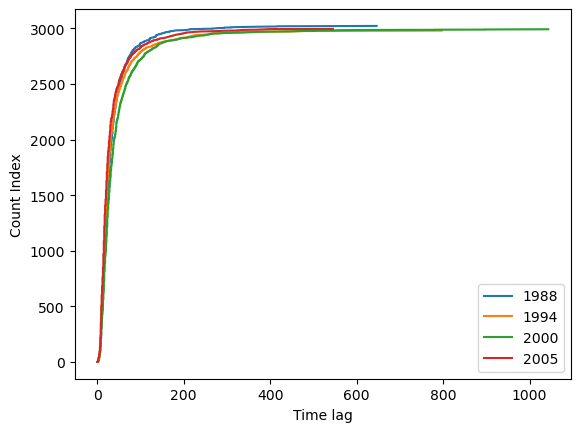

In [24]:
for yr in [1988, 1994, 2000, 2005]:
    x = time_lag_sort[time_lag_sort['AccYear']==yr].time_lag
    plt.plot(x, [i for i in range(len(x))], label = yr)
plt.xlabel('Time lag')
plt.ylabel('Count Index')
plt.legend()
plt.show()

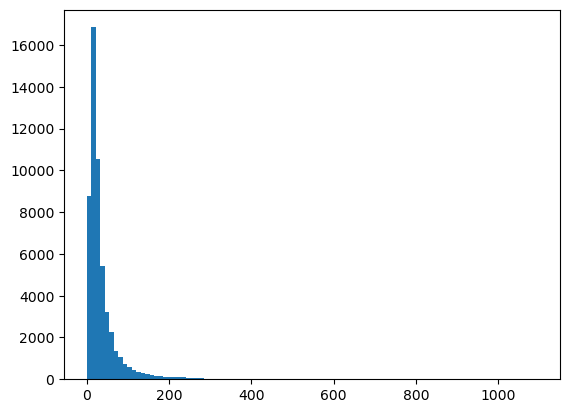

In [25]:
plt.hist(time_lag_sort.time_lag, bins=100)  #roughly 10 days per bin
plt.show()

The overall time lag histogram looks like gamma distribution. Split by years, the curves look similar and the time lag does not seem to have consistent 'lag inflation'.

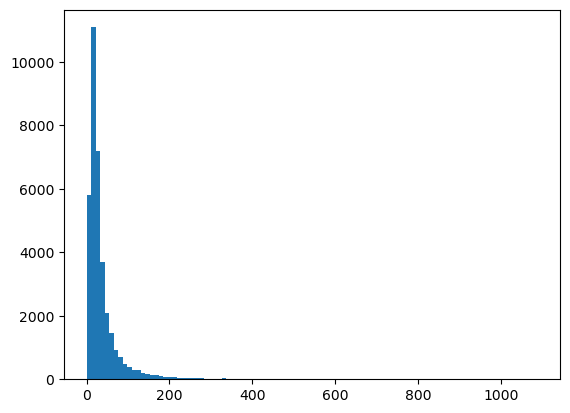

In [26]:
time_lag_sort2 = df_submit_test[['time_lag', 'AccYear']].sort_values(by='time_lag')
plt.hist(time_lag_sort2.time_lag, bins=100)  #roughly 10 days per bin
plt.show()

The time lag in testing dataset has similar distribution shape. Reminder: both have mean around 39 days. Let's see how it relates to development factor.

In [27]:
import math

In [28]:
df['time_lag_group']=df['time_lag'].apply(lambda x: min(math.trunc(x/30)*30, 300))

In [29]:
def lag(df, extreme=1e+15, metric='UltimateClaim', aggfunc=np.sum):
    table_lag = np.round(pd.pivot_table(df[df[metric]<extreme], 
        values=['InitialClaim', 'UltimateClaim'], 
        index=['time_lag_group'], aggfunc={aggfunc}))
    table_lag['dev_factor'] = table_lag.UltimateClaim/table_lag.InitialClaim
    return table_lag

In [30]:
table_lag = lag(df)
table_lag

,InitialClaim,UltimateClaim,dev_factor
,sum,sum,
time_lag_group,,,
0,249372844,359321232.0,1.440900
30,96911077,136017153.0,1.403525
60,31441287,39874619.0,1.268225
90,14156428,17778316.0,1.255848
120,7516257,9748881.0,1.297039
150,4784724,5780026.0,1.208017
180,3814408,4637575.0,1.215805
210,2719446,3407465.0,1.253000


In [31]:
table_lag_avg = lag(df, aggfunc=np.average)
table_lag_avg

,InitialClaim,UltimateClaim,dev_factor
,average,average,
time_lag_group,,,
0,7344.0,10582.0,1.440904
30,8048.0,11296.0,1.403579
60,8714.0,11052.0,1.268304
90,8954.0,11245.0,1.255863
120,8580.0,11129.0,1.297086
150,9569.0,11560.0,1.208068
180,11665.0,14182.0,1.215774
210,9747.0,12213.0,1.253001


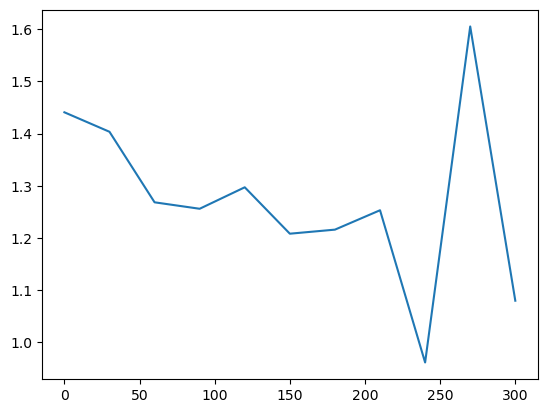

In [32]:
plt.plot(table_lag.dev_factor)
plt.show()

In [33]:
x = np.array(table_lag.dev_factor.index).reshape(-1,1)
y = np.array(table_lag.dev_factor).reshape(-1,1)
reg = LinearRegression().fit(x, y)
print('coefficient: ', reg.coef_)
print('intercept: ', reg.intercept_)
print('R2: ', reg.score(x, y))

coefficient:  [[-0.00060844]]
intercept:  [1.36293183]
R2:  0.12241732613480738


In [34]:
table_lag_100k = lag(df, extreme=100000)
table_lag_100k

,InitialClaim,UltimateClaim,dev_factor
,sum,sum,
time_lag_group,,,
0,222663993,258279090.0,1.159950
30,85776482,95719800.0,1.115921
60,26216004,27224013.0,1.038450
90,12692935,12801782.0,1.008575
120,6863755,7134259.0,1.039410
150,4062142,4191089.0,1.031744
180,3248668,3386768.0,1.042510
210,2528946,2697922.0,1.066817


After removing large ultimate claims, many development factors become close to 1. However, it is not practical to remove before ultimate claim is known. Let's see what happens if large 'initial' claims are removed instead.

In [35]:
# pd.DataFrame(df.columns)

In [36]:
table_lag_100k_init = lag(df, extreme=100000, metric='InitialClaim')
table_lag_100k_init

,InitialClaim,UltimateClaim,dev_factor
,sum,sum,
time_lag_group,,,
0,222276915,342379083.0,1.540327
30,84463599,125795448.0,1.489345
60,25469885,36160581.0,1.419739
90,11829311,16018266.0,1.354117
120,6475717,9107654.0,1.406432
150,3554272,4663490.0,1.312080
180,3266408,4228387.0,1.294507
210,2445227,3275553.0,1.339570


In contrast, most development factors increase! Let's also see what happens among accident years if initial claims are used as the metric instead.

In [37]:
table_dev_100k_init = development(df, 100000, metric='InitialClaim')
table_dev_100k_init

,Initial/Wage,InitialClaim,UltimateClaim,WeeklyWages,time_lag,dev_factor,injury_factor
,mean,mean,mean,mean,mean,,
AccYear,,,,,,,
1988,11.0,3335.0,6183.0,357.0,36.0,1.854,17.3
1989,9.0,2818.0,6160.0,359.0,37.0,2.186,17.2
1990,20.0,2627.0,5518.0,353.0,38.0,2.100,15.6
1991,26.0,2993.0,6246.0,389.0,35.0,2.087,16.1
1992,10.0,3366.0,7048.0,401.0,36.0,2.094,17.6
1993,14.0,4582.0,7543.0,407.0,35.0,1.646,18.5
1994,41.0,5485.0,7789.0,400.0,37.0,1.420,19.5
1995,51.0,3902.0,5774.0,337.0,41.0,1.480,17.1


In [38]:
table_dev_100k_init.to_csv('dev_factor_small.csv', encoding='utf-8')

Again, most development factors increase. Above is exported for feature engineering.

In [39]:
def AccYear_lag(df, values='UltimateClaim'):
    table = np.round(pd.pivot_table(df, values = values, columns=['time_lag_group'],
        index=['AccYear'], aggfunc={np.sum}))
    return table

In [40]:
large, small = {}, {}

large['df'] = df[df['InitialClaim']>=100000]
small['df'] = df[df['InitialClaim']<100000]

for d in [large, small]:
    d['Ult_yr_lag'] = AccYear_lag(d['df'], 'UltimateClaim')
    d['Init_yr_lag'] = AccYear_lag(d['df'], 'InitialClaim')
    d['dev_yr_lag'] = d['Ult_yr_lag']/d['Init_yr_lag']

In [41]:
np.round(large['Ult_yr_lag'])

sum                                                     \
time_lag_group        0          30        60        90        120       150   
AccYear                                                                        
1988             285820.0        NaN       NaN       NaN       NaN       NaN   
1989             274352.0   102585.0       NaN       NaN  100227.0       NaN   
1990                  NaN    76136.0       NaN       NaN       NaN       NaN   
1991             148838.0        NaN       NaN       NaN       NaN       NaN   
1992             501899.0   242255.0       NaN       NaN       NaN       NaN   
1993             628238.0        NaN       NaN       NaN       NaN       NaN   
1994                  NaN        NaN  180336.0       NaN       NaN       NaN   
1995             259057.0   284615.0       NaN       NaN       NaN       NaN   
1996             263163.0   371732.0   48004.0       NaN       NaN       NaN   
1997             193473.0    34762.0       NaN       NaN       NaN       NaN   
1998             370071.0        NaN       NaN       NaN   56101.0       NaN   
1999             430032.0   229996.0  179795.0   46898.0       NaN       NaN   
2000            1463693.0  1481307.0  448914.0  244771.0  123381.0  106485.0   
2001             936676.0  2099993.0  282913.0  257008.0   72916.0  108221.0   
2002            2644876.0   911732.0  848430.0  135091.0       NaN       NaN   
2003            1485088.0  1299874.0  329529.0       NaN       NaN  128516.0   
2004            3668246.0  1842389.0  449673.0  185409.0   99677.0  248483.0   
2005            3388627.0  1244329.0  946443.0  890873.0  188925.0  524831.0   

                                                        
time_lag_group       180       210       240       300  
AccYear                                                 
1988                 NaN       NaN       NaN       NaN  
1989             34165.0       NaN       NaN   48398.0  
1990                 NaN       NaN       NaN       NaN  
1991                 NaN       NaN       NaN       NaN  
1992                 NaN       NaN       NaN       NaN  
1993                 NaN       NaN       NaN       NaN  
1994                 NaN       NaN       NaN       NaN  
1995                 NaN       NaN       NaN   36205.0  
1996                 NaN       NaN       NaN   37110.0  
1997            158473.0       NaN       NaN       NaN  
1998                 NaN       NaN       NaN       NaN  
1999                 NaN       NaN       NaN  526364.0  
2000                 NaN       NaN       NaN  126197.0  
2001             63175.0       NaN  303927.0  244422.0  
2002                 NaN       NaN       NaN       NaN  
2003                 NaN       NaN       NaN  516528.0  
2004                 NaN  131913.0   62717.0  179113.0  
2005            153376.0       NaN  122034.0  871830.0

In [42]:
np.round(large['Init_yr_lag'])

sum                                                      \
time_lag_group        0          30         60        90        120       150   
AccYear                                                                         
1988             630000.0        NaN        NaN       NaN       NaN       NaN   
1989             467000.0   120000.0        NaN       NaN  102000.0       NaN   
1990                  NaN   121000.0        NaN       NaN       NaN       NaN   
1991             214500.0        NaN        NaN       NaN       NaN       NaN   
1992             377000.0   707000.0        NaN       NaN       NaN       NaN   
1993             713305.0        NaN        NaN       NaN       NaN       NaN   
1994                  NaN        NaN   125000.0       NaN       NaN       NaN   
1995             985000.0   400000.0        NaN       NaN       NaN       NaN   
1996             375000.0   692192.0   170000.0       NaN       NaN       NaN   
1997             370297.0   105000.0        NaN       NaN       NaN       NaN   
1998             850000.0        NaN        NaN       NaN  170000.0       NaN   
1999             947630.0   244000.0   232000.0  150999.0       NaN       NaN   
2000            1484500.0  1192000.0  1128000.0  490000.0  306000.0  246000.0   
2001            2194001.0  2098000.0   215000.0  145000.0  110000.0  221000.0   
2002            2703682.0  1303000.0  1527200.0  526000.0       NaN       NaN   
2003            2531405.0  1443968.0   325307.0       NaN       NaN  162369.0   
2004            7340726.0  2635906.0   331915.0  150000.0  150000.0  207933.0   
2005            4911883.0  1385412.0  1916980.0  865118.0  202540.0  393150.0   

                                                        
time_lag_group       180       210       240       300  
AccYear                                                 
1988                 NaN       NaN       NaN       NaN  
1989            102000.0       NaN       NaN  156000.0  
1990                 NaN       NaN       NaN       NaN  
1991                 NaN       NaN       NaN       NaN  
1992                 NaN       NaN       NaN       NaN  
1993                 NaN       NaN       NaN       NaN  
1994                 NaN       NaN       NaN       NaN  
1995                 NaN       NaN       NaN  100000.0  
1996                 NaN       NaN       NaN  215000.0  
1997            120000.0       NaN       NaN       NaN  
1998                 NaN       NaN       NaN       NaN  
1999                 NaN       NaN       NaN  614000.0  
2000                 NaN       NaN       NaN  215000.0  
2001            226000.0       NaN  505000.0  370000.0  
2002                 NaN       NaN       NaN       NaN  
2003                 NaN       NaN       NaN  797120.0  
2004                 NaN  274219.0  104000.0  236448.0  
2005            100000.0       NaN  103000.0  577362.0

In [43]:
np.round(small['Ult_yr_lag'])

sum                                               \
time_lag_group         0           30         60         90         120   
AccYear                                                                   
1988            11201494.0   4925971.0  1394293.0   428911.0   342646.0   
1989            11310646.0   4736784.0   957365.0   561303.0   171778.0   
1990            11100974.0   3532790.0   824163.0   368452.0   126883.0   
1991            11301460.0   4736938.0   843144.0   597634.0   100726.0   
1992            13629235.0   4712079.0  1211907.0   568345.0   237261.0   
1993            14336877.0   4981783.0  1610230.0   544986.0   190578.0   
1994            13702636.0   5443582.0  2510605.0   512904.0   220257.0   
1995            11048973.0   3449252.0  1528466.0   434966.0   205277.0   
1996            11566327.0   4315932.0   857915.0   461241.0   105313.0   
1997            12180059.0   5036246.0  1410315.0   541193.0   252893.0   
1998            14080567.0   5266943.0  1393468.0   621549.0   636990.0   
1999            16608052.0   5010259.0  2486665.0   823587.0   510391.0   
2000            19117549.0  10464780.0  2689893.0  2122815.0   830397.0   
2001            23288552.0  11592359.0  4303660.0  1532817.0   939837.0   
2002            28852686.0  10867679.0  2146230.0  1543505.0  1012567.0   
2003            30695235.0  11594124.0  2402960.0  1300120.0  1176677.0   
2004            39225920.0  13107147.0  3053513.0  1805534.0  1050541.0   
2005            49131843.0  12020801.0  4535790.0  1248404.0   996644.0   

                                                                             
time_lag_group       150       180       210       240       270        300  
AccYear                                                                      
1988             89713.0    6747.0   46557.0  115604.0   37073.0    89749.0  
1989            124663.0  120503.0   21677.0   73420.0  147694.0    63207.0  
1990             52922.0   78781.0   53588.0   13429.0   18509.0   219404.0  
1991             81924.0  101936.0  100240.0   51175.0       NaN   641383.0  
1992            172270.0  114603.0  213034.0   82921.0   16996.0   311483.0  
1993            429633.0   80421.0   86111.0   85613.0  100862.0   159617.0  
1994            307510.0  104166.0  202924.0   93420.0   23102.0    89906.0  
1995            171186.0   69633.0   69810.0   32184.0    9364.0   176311.0  
1996            157793.0  125756.0  134331.0   59832.0   26217.0   340106.0  
1997            201749.0  229772.0  117878.0   84501.0   51660.0   918135.0  
1998            242551.0   80894.0  136425.0   63116.0   18643.0   528690.0  
1999            112717.0  182271.0  408144.0  130581.0   32134.0   516992.0  
2000            257861.0  628607.0  209866.0  171283.0   15995.0   318141.0  
2001            445601.0  373087.0  431612.0  112136.0   98580.0  1282238.0  
2002            119929.0  277030.0  428391.0   80960.0   44033.0   651463.0  
2003            701182.0  238595.0  338382.0   71089.0    3929.0   618932.0  
2004            590493.0  824723.0  108140.0  629179.0    8437.0   461046.0  
2005            403792.0  590863.0  168444.0   55795.0   44249.0   424171.0

In [44]:
np.round(small['Init_yr_lag'])

sum                                             \
time_lag_group         0          30         60         90        120   
AccYear                                                                 
1988             6314882.0  2428565.0   746028.0   216545.0  167694.0   
1989             4859645.0  2244272.0   531482.0   332670.0  104740.0   
1990             4637380.0  1981270.0   523390.0   196091.0  105546.0   
1991             5308839.0  2223154.0   366117.0   258227.0   83132.0   
1992             6193290.0  2385248.0   603499.0   331636.0  100285.0   
1993             8728959.0  3053177.0   859114.0   358365.0  176338.0   
1994             9652815.0  3878693.0  1308561.0   483208.0  291486.0   
1995             7255466.0  2324010.0   897658.0   385190.0  138440.0   
1996             8213902.0  3512401.0   939460.0   316060.0  106220.0   
1997             9589495.0  3667868.0  1475031.0   483927.0  241250.0   
1998            11341272.0  4638324.0  1234591.0   702296.0  521871.0   
1999            12207099.0  4334628.0  1748800.0   787590.0  354600.0   
2000            13633823.0  7412988.0  2239000.0  1165950.0  673100.0   
2001            16941261.0  8113586.0  3188897.0  1385947.0  729580.0   
2002            19577999.0  8173345.0  1840680.0  1265151.0  697900.0   
2003            21632261.0  8010107.0  1762630.0   876753.0  695963.0   
2004            26599912.0  8591474.0  2096481.0  1288895.0  666218.0   
2005            29588615.0  7490489.0  3108466.0   994810.0  621354.0   

                                                                           
time_lag_group       150       180       210       240      270       300  
AccYear                                                                    
1988             57613.0    2570.0   50640.0   29897.0  27570.0   34165.0  
1989             54195.0   72825.0    9580.0   52445.0  16790.0   87295.0  
1990             41920.0   88144.0   53923.0   12010.0  13240.0  149235.0  
1991             68610.0   46670.0  130830.0    9830.0      NaN  395605.0  
1992             62350.0  107310.0   89966.0   49400.0  15888.0  219816.0  
1993            174437.0   67570.0   56745.0   69325.0  34040.0  153833.0  
1994            287468.0  102810.0  146651.0  109706.0  21190.0   63562.0  
1995            218056.0   82848.0   53069.0   52209.0  17075.0  196900.0  
1996            130010.0   31975.0   99625.0   53600.0  24780.0  258480.0  
1997            230490.0  128760.0   87051.0  119220.0  69050.0  623500.0  
1998            202200.0   62050.0   90550.0   38000.0  19800.0  539100.0  
1999            154500.0  155750.0  263300.0  115063.0  28500.0  579770.0  
2000            232800.0  183800.0  266000.0  199300.0  18500.0  346550.0  
2001            477000.0  423500.0  410845.0  156500.0  60500.0  742300.0  
2002            106000.0  202729.0   98634.0  106000.0  42000.0  603401.0  
2003            509110.0  262653.0  283500.0  104001.0   4500.0  684362.0  
2004            329986.0  766440.0   86653.0  577715.0   4000.0  423138.0  
2005            217527.0  478004.0  167665.0   30000.0  17000.0  249828.0

In [45]:
np.round(large['dev_yr_lag'],2)

sum                                                      
time_lag_group   0     30    60    90    120   150   180   210   240   300
AccYear                                                                   
1988            0.45   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
1989            0.59  0.85   NaN   NaN  0.98   NaN  0.33   NaN   NaN  0.31
1990             NaN  0.63   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
1991            0.69   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
1992            1.33  0.34   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
1993            0.88   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
1994             NaN   NaN  1.44   NaN   NaN   NaN   NaN   NaN   NaN   NaN
1995            0.26  0.71   NaN   NaN   NaN   NaN   NaN   NaN   NaN  0.36
1996            0.70  0.54  0.28   NaN   NaN   NaN   NaN   NaN   NaN  0.17
1997            0.52  0.33   NaN   NaN   NaN   NaN  1.32   NaN   NaN   NaN
1998            0.44   NaN   NaN   NaN  0.33   NaN   NaN   NaN   NaN   NaN
1999            0.45  0.94  0.77  0.31   NaN   NaN   NaN   NaN   NaN  0.86
2000            0.99  1.24  0.40  0.50  0.40  0.43   NaN   NaN   NaN  0.59
2001            0.43  1.00  1.32  1.77  0.66  0.49  0.28   NaN  0.60  0.66
2002            0.98  0.70  0.56  0.26   NaN   NaN   NaN   NaN   NaN   NaN
2003            0.59  0.90  1.01   NaN   NaN  0.79   NaN   NaN   NaN  0.65
2004            0.50  0.70  1.35  1.24  0.66  1.20   NaN  0.48  0.60  0.76
2005            0.69  0.90  0.49  1.03  0.93  1.33  1.53   NaN  1.18  1.51

In [46]:
np.round(small['dev_yr_lag'],2)

sum                                                        \
time_lag_group   0     30    60    90    120   150   180   210   240   270   
AccYear                                                                      
1988            1.77  2.03  1.87  1.98  2.04  1.56  2.63  0.92  3.87  1.34   
1989            2.33  2.11  1.80  1.69  1.64  2.30  1.65  2.26  1.40  8.80   
1990            2.39  1.78  1.57  1.88  1.20  1.26  0.89  0.99  1.12  1.40   
1991            2.13  2.13  2.30  2.31  1.21  1.19  2.18  0.77  5.21   NaN   
1992            2.20  1.98  2.01  1.71  2.37  2.76  1.07  2.37  1.68  1.07   
1993            1.64  1.63  1.87  1.52  1.08  2.46  1.19  1.52  1.23  2.96   
1994            1.42  1.40  1.92  1.06  0.76  1.07  1.01  1.38  0.85  1.09   
1995            1.52  1.48  1.70  1.13  1.48  0.79  0.84  1.32  0.62  0.55   
1996            1.41  1.23  0.91  1.46  0.99  1.21  3.93  1.35  1.12  1.06   
1997            1.27  1.37  0.96  1.12  1.05  0.88  1.78  1.35  0.71  0.75   
1998            1.24  1.14  1.13  0.89  1.22  1.20  1.30  1.51  1.66  0.94   
1999            1.36  1.16  1.42  1.05  1.44  0.73  1.17  1.55  1.13  1.13   
2000            1.40  1.41  1.20  1.82  1.23  1.11  3.42  0.79  0.86  0.86   
2001            1.37  1.43  1.35  1.11  1.29  0.93  0.88  1.05  0.72  1.63   
2002            1.47  1.33  1.17  1.22  1.45  1.13  1.37  4.34  0.76  1.05   
2003            1.42  1.45  1.36  1.48  1.69  1.38  0.91  1.19  0.68  0.87   
2004            1.47  1.53  1.46  1.40  1.58  1.79  1.08  1.25  1.09  2.11   
2005            1.66  1.60  1.46  1.25  1.60  1.86  1.24  1.00  1.86  2.60   

                      
time_lag_group   300  
AccYear               
1988            2.63  
1989            0.72  
1990            1.47  
1991            1.62  
1992            1.42  
1993            1.04  
1994            1.41  
1995            0.90  
1996            1.32  
1997            1.47  
1998            0.98  
1999            0.89  
2000            0.92  
2001            1.73  
2002            1.08  
2003            0.90  
2004            1.09  
2005            1.70

In [47]:
# number of large claims (>=100k) by accident year
df_large_claim = df[df['InitialClaim'] >= 100000]

np.round(pd.pivot_table(df_large_claim, 
        values=['InitialClaim'], 
        index=['AccYear'], aggfunc={np.count_nonzero}))

,InitialClaim
,count_nonzero
AccYear,
1988,2
1989,8
1990,1
1991,2
1992,4
1993,6
1994,1
1995,5


In [48]:
def absolute_chart(table, index=slice(0, None)):
    for col in table.columns[index]:
        plt.plot(table[col], label = col)
    plt.xlabel('Year')
    plt.legend()
    plt.show()

In [49]:
def relative_chart(table, index=slice(0, None)):
    for col in table.columns[index]:
        plt.plot(table[col]/table.loc[1988].at[col], label = col)
    plt.xlabel('Year')
    plt.ylabel('Relative to 1988')
    plt.legend()
    plt.show()

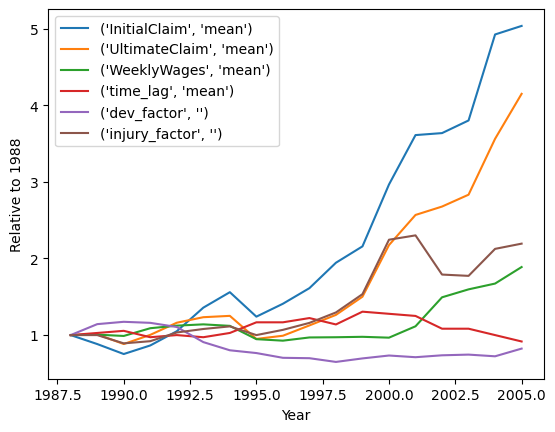

In [50]:
relative_chart(table_dev, index=slice(1, None))

In [51]:
table_dev2 = np.round(pd.pivot_table(df_submit_test, 
    values=['time_lag', 'WeeklyWages', 'Initial/Wage', 'InitialClaim'], 
    index=['AccYear'], aggfunc={np.mean}))
table_dev2

,Initial/Wage,InitialClaim,WeeklyWages,time_lag
,mean,mean,mean,mean
AccYear,,,,
1988,12.0,3585.0,351.0,37.0
1989,11.0,3208.0,367.0,37.0
1990,15.0,2799.0,344.0,36.0
1991,9.0,3135.0,395.0,33.0
1992,10.0,3334.0,405.0,35.0
1993,18.0,5119.0,405.0,33.0
1994,34.0,5533.0,403.0,38.0
1995,47.0,4300.0,333.0,41.0


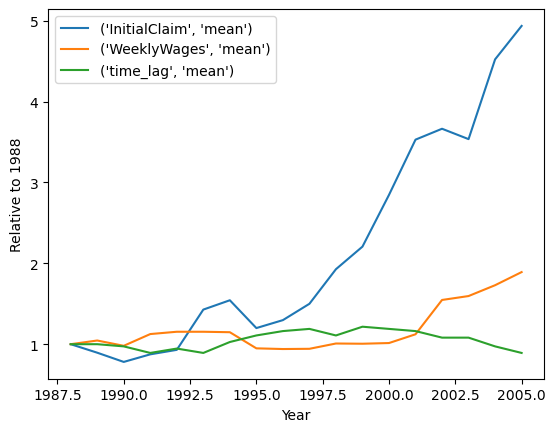

In [52]:
relative_chart(table_dev2, index=slice(1, None))

Both datasets have similar trend.

In [53]:
df[['AccYear', 'WeeklyWages', 'HoursWorkedPerWeek']].nsmallest(100, 'WeeklyWages')

,AccYear,WeeklyWages,HoursWorkedPerWeek
324,1999,1.0,40.0
904,2001,1.0,40.0
1102,1997,1.0,10.0
2098,1994,1.0,38.0
2162,1999,1.0,38.0
...,...,...,...
44107,1994,1.0,38.0
44242,1999,1.0,38.0
45066,2001,1.0,40.0
45096,1999,1.0,38.0


In [54]:
df_submit_test[['AccYear', 'WeeklyWages', 'HoursWorkedPerWeek']].nsmallest(100, 'WeeklyWages')

,AccYear,WeeklyWages,HoursWorkedPerWeek
66,1995,1.00,1.0
1141,1999,1.00,38.0
1160,2005,1.00,5.0
1248,2001,1.00,38.0
2450,2001,1.00,38.0
...,...,...,...
28569,2000,5.00,38.0
32759,2001,5.00,40.0
5548,1988,5.25,37.5
2893,1997,5.37,35.0


Above weekly wages are clearly wrong, especially when most are associated with 35-40 hours worked.

In [55]:
df[['AccYear', 'WeeklyWages', 'HoursWorkedPerWeek']].nsmallest(870, 'WeeklyWages')

,AccYear,WeeklyWages,HoursWorkedPerWeek
324,1999,1.00,40.0
904,2001,1.00,40.0
1102,1997,1.00,10.0
2098,1994,1.00,38.0
2162,1999,1.00,38.0
...,...,...,...
10096,1988,99.61,9.0
49276,1989,99.61,38.0
4904,2002,99.74,15.0
1808,2000,99.75,20.0


In [56]:
df['InitialClaim'].nsmallest(100).tolist()

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 9,
 9,
 10,
 10,
 10,
 30,
 40,
 42,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 55,
 60,
 60,
 60,
 60,
 70,
 70,
 70,
 70,
 70,
 70,
 75,
 75,
 75,
 77,
 77,
 80,
 80,
 80,
 90,
 90,
 90,
 90,
 90,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100]

In [57]:
df_submit_test['InitialClaim'].nsmallest(100).tolist()

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 10,
 20,
 30,
 30,
 31,
 33,
 33,
 40,
 50,
 50,
 50,
 50,
 50,
 60,
 70,
 70,
 70,
 70,
 70,
 75,
 75,
 75,
 80,
 80,
 80,
 84,
 84,
 85,
 90,
 90,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100]

There are about 870 training records below weekly wage 100.

### Demographic and Missing/ unknown values

In [58]:
def demograph(df, metric=np.count_nonzero, row='AccYear'):
    #metric: numpy function to aggregate
    table = np.round(pd.pivot_table(df, 
        values=['InitialClaim'], 
        columns=['Gender', 'MaritalStatus'],
        index=row, aggfunc={metric}))
    return table

In [59]:
table_count = demograph(df, np.count_nonzero)
table_count

InitialClaim                                         
              count_nonzero                                         
Gender                    F                    M                   U
MaritalStatus             M      S     U       M       S      U    M
AccYear                                                             
1988                  272.0  309.0  40.0  1102.0  1138.0  162.0  NaN
1989                  253.0  266.0  71.0   881.0  1223.0  282.0  NaN
1990                  376.0  289.0  16.0  1105.0  1139.0   46.0  NaN
1991                  357.0  250.0  46.0  1067.0  1034.0  216.0  NaN
1992                  404.0  213.0  78.0  1019.0   907.0  394.0  1.0
1993                  349.0  211.0  47.0  1230.0   904.0  256.0  NaN
1994                  298.0  236.0  85.0   875.0   982.0  500.0  1.0
1995                  274.0  292.0  75.0   930.0   988.0  424.0  NaN
1996                  298.0  305.0  53.0  1007.0  1159.0  212.0  NaN
1997                  329.0  292.0  49.0  1059.0  1139.0  163.0  NaN
1998                  258.0  302.0  57.0  1140.0  1056.0  151.0  NaN
1999                  353.0  372.0  54.0   941.0  1136.0  143.0  NaN
2000                  272.0  372.0  40.0   963.0  1160.0  185.0  NaN
2001                  315.0  441.0  63.0   839.0  1220.0  150.0  NaN
2002                  322.0  445.0  56.0   807.0  1219.0  161.0  NaN
2003                  282.0  416.0  62.0   711.0  1307.0  197.0  NaN
2004                  275.0  415.0  85.0   683.0  1325.0  249.0  NaN
2005                  203.0  340.0  98.0   664.0  1359.0  328.0  NaN

In [60]:
table_count2 = demograph(df_submit_test, np.count_nonzero)
table_count2

InitialClaim                        
              count_nonzero                        
Gender                    F             M          
MaritalStatus             M    S   U    M    S    U
AccYear                                            
1988                    188  201  23  736  727  101
1989                    183  185  42  600  805  208
1990                    262  188  12  736  780   50
1991                    226  195  37  713  713  138
1992                    236  167  55  723  541  255
1993                    255  132  24  824  571  186
1994                    181  177  59  608  671  323
1995                    175  196  42  629  707  267
1996                    166  198  21  637  798  146
1997                    222  190  24  664  762  107
1998                    198  188  30  806  725   89
1999                    229  231  32  621  797   91
2000                    182  233  27  668  781  114
2001                    215  276  44  522  807  108
2002                    193  268  37  556  829  106
2003                    164  300  29  517  889  123
2004                    145  264  54  489  841  175
2005                    138  274  77  412  906  194

In [61]:
table_avg_init = demograph(df, np.mean)
table_avg_init

InitialClaim                                               \
                      mean                                                
Gender                   F                          M                     
MaritalStatus            M        S        U        M        S        U   
AccYear                                                                   
1988                3937.0   2822.0   3095.0   3717.0   3613.0   2668.0   
1989                2904.0   4091.0   3399.0   3023.0   3111.0   2767.0   
1990                3525.0   2188.0   6063.0   2821.0   2294.0   3007.0   
1991                3444.0   3043.0   2177.0   3297.0   2761.0   2947.0   
1992                5700.0   3276.0   2790.0   4163.0   2927.0   2830.0   
1993                5218.0   4246.0   4671.0   5908.0   3461.0   4312.0   
1994                7152.0   4760.0   7572.0   6484.0   4169.0   5593.0   
1995                5009.0   3578.0   5114.0   4975.0   2883.0   6675.0   
1996                5081.0   4228.0  11233.0   5989.0   3607.0   7208.0   
1997                6949.0   4968.0   7328.0   6524.0   4332.0   8420.0   
1998                7899.0   6472.0  12564.0   7284.0   5230.0  12414.0   
1999                9138.0   6827.0  14828.0   8409.0   6041.0  11029.0   
2000               11352.0   8714.0  18908.0  10750.0   8813.0  20378.0   
2001               18529.0  10091.0  15920.0  15634.0   8950.0  22587.0   
2002               16989.0  11672.0  19791.0  15167.0   9536.0  19477.0   
2003               17599.0  12383.0  22025.0  15006.0   9988.0  24737.0   
2004               22293.0  16173.0  31122.0  18497.0  14562.0  21871.0   
2005               25933.0  17303.0  28770.0  19029.0  12710.0  29042.0   

                       
                       
Gender              U  
MaritalStatus       M  
AccYear                
1988              NaN  
1989              NaN  
1990              NaN  
1991              NaN  
1992            700.0  
1993              NaN  
1994           7500.0  
1995              NaN  
1996              NaN  
1997              NaN  
1998              NaN  
1999              NaN  
2000              NaN  
2001              NaN  
2002              NaN  
2003              NaN  
2004              NaN  
2005              NaN

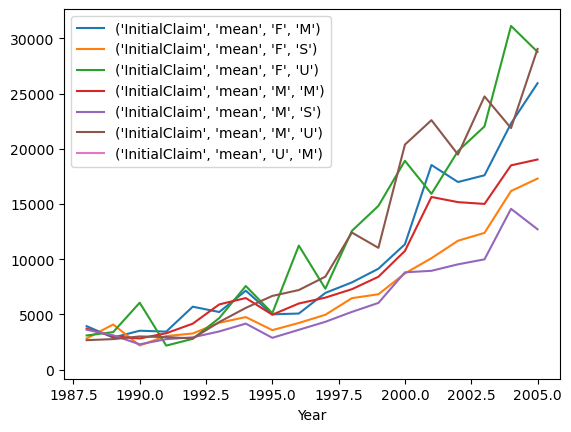

In [62]:
absolute_chart(table_avg_init)

In [63]:
table_avg_init2 = demograph(df_submit_test, np.mean)
table_avg_init2

InitialClaim                                             
                      mean                                             
Gender                   F                          M                  
MaritalStatus            M        S        U        M        S        U
AccYear                                                                
1988                4527.0   3349.0   4141.0   4150.0   2952.0   2647.0
1989                4212.0   5044.0   3730.0   3077.0   2519.0   3627.0
1990                3838.0   2331.0   2793.0   2719.0   2613.0   3191.0
1991                3604.0   2981.0   5224.0   3337.0   2598.0   3817.0
1992                4370.0   3040.0   2920.0   3512.0   2749.0   3403.0
1993                5524.0   3437.0   5266.0   6440.0   3637.0   4530.0
1994                6966.0   5776.0   8610.0   6348.0   4287.0   5092.0
1995                9458.0   3548.0   6381.0   3900.0   2837.0   5976.0
1996                6941.0   3633.0   9363.0   4717.0   3654.0   7920.0
1997                6651.0   5081.0  10850.0   6029.0   3674.0  10102.0
1998                8022.0   6983.0  14991.0   6937.0   5448.0  13223.0
1999                9557.0   8432.0  16578.0   8090.0   6374.0  11632.0
2000               12320.0   8041.0  14383.0  11165.0   8315.0  17740.0
2001               12979.0  11390.0  20398.0  13804.0  10501.0  22611.0
2002               17143.0  10839.0  24892.0  14703.0  10035.0  23600.0
2003               20511.0  12212.0  25617.0  12317.0  10481.0  17701.0
2004               16393.0  16823.0  22578.0  17777.0  12291.0  27651.0
2005               22262.0  16713.0  27532.0  17903.0  14537.0  26417.0

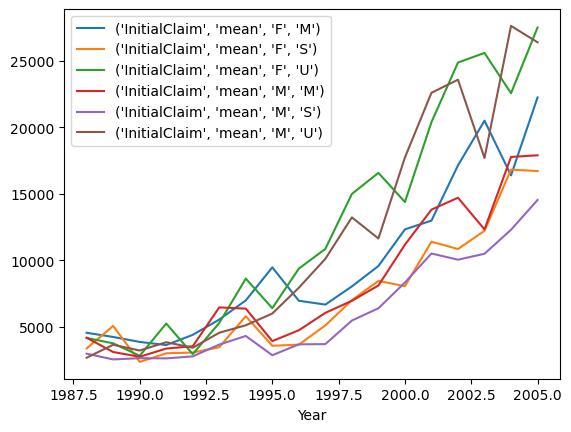

In [64]:
absolute_chart(table_avg_init2)

In [65]:
table_population = demograph(df, row='PartTimeFullTime')
table_population

InitialClaim                                              
                 count_nonzero                                              
Gender                       F                       M                     U
MaritalStatus                M       S      U        M        S       U    M
PartTimeFullTime                                                            
F                       4295.0  4475.0  825.0  16347.0  19153.0  3985.0  2.0
P                       1195.0  1291.0  250.0    676.0   1242.0   234.0  NaN

In [66]:
table_population2 = demograph(df_submit_test, row='PartTimeFullTime')
table_population2

InitialClaim                               
                 count_nonzero                               
Gender                       F                 M             
MaritalStatus                M     S    U      M      S     U
PartTimeFullTime                                             
F                         2789  3014  509  11032  12840  2632
P                          769   849  160    429    810   149

'Unknown' gender is negligible and only present in training data. So we may simply replace it with the mode, i.e. 'Male'.

In [67]:
popu_InitialClaim = demograph(df, row='PartTimeFullTime', metric=np.mean)
popu_InitialClaim

InitialClaim                                             \
                         mean                                              
Gender                      F                         M                    
MaritalStatus               M       S        U        M       S        U   
PartTimeFullTime                                                           
F                      9287.0  7738.0  13044.0   7858.0  6223.0  10775.0   
P                      9971.0  8019.0  13739.0  11160.0  8704.0  14461.0   

                          
                          
Gender                 U  
MaritalStatus          M  
PartTimeFullTime          
F                 4100.0  
P                    NaN

In [68]:
popu_InitialClaim2 = demograph(df_submit_test, row='PartTimeFullTime', metric=np.mean)
popu_InitialClaim2

InitialClaim                                           
                         mean                                           
Gender                      F                         M                 
MaritalStatus               M       S        U        M       S        U
PartTimeFullTime                                                        
F                      9034.0  7794.0  12634.0   7344.0  6298.0  10725.0
P                      9315.0  8676.0  17733.0  12387.0  8030.0  13497.0

'Unknown MaritalStatus' occupies roughly 10% by count and its mean initial claim is significantly higher. It should be kept as a separated category.

## NaN

In [69]:
np.mean(df[df['MaritalStatus'].isna()].InitialClaim)

2074.9310344827586

In [70]:
len(df[df['MaritalStatus'].isna()].InitialClaim)

29

In [71]:
np.mean(df_submit_test[df_submit_test['MaritalStatus'].isna()].InitialClaim)

1424.4444444444443

In [72]:
len(df_submit_test[df_submit_test['MaritalStatus'].isna()].InitialClaim)

18

'Missing MaritalStatus' has very low average initial claim, so it is not advisable to group with 'Unknown MaritalStatus'.

'MaritalStatus' can be categorised by order of average initial claim, as:

Nan: 0,

Single: 1,

Married: 2,

Unknown: 3

In [73]:
df_submit_test['MaritalStatus'].unique()

array(['S', 'M', 'U', nan], dtype=object)

In [74]:
df_submit_test['Gender'].unique()

array(['M', 'F'], dtype=object)

In [75]:
df_submit_test['PartTimeFullTime'].unique()

array(['F', 'P'], dtype=object)

Test data has no new categories.

In [76]:
df['PartTimeFullTime'].replace(['P', 'F'], [0, 1] , inplace=True)
df['PartTimeFullTime'] = df['PartTimeFullTime'].astype('category')

In [77]:
df[df.isna().any(axis=1)]

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,...,InitialClaim,UltimateClaim,DateAcc,AccYear,AccMonth,AccWeekDay,AccHour,time_lag,Initial/Wage,time_lag_group
1042,WC3603450,1992-09-25 14:00:00,1992-10-09,53,M,NaN,0,0,465.40,1,...,500,2234.095678,1992-09-25,1992,9,4,14,14.0,1.074345,0
7587,WC3938584,1992-05-07 07:00:00,1992-05-23,58,F,NaN,0,0,446.52,1,...,3500,6762.469123,1992-05-07,1992,5,3,7,16.0,7.838395,0
7592,WC2469641,1989-10-09 09:00:00,1990-07-15,17,M,NaN,0,0,184.00,1,...,345,409.522438,1989-10-09,1989,10,0,9,279.0,1.875000,270
10482,WC9825722,2005-07-12 16:00:00,2005-10-27,42,M,NaN,0,0,500.00,1,...,1000,625.423274,2005-07-12,2005,7,1,16,107.0,2.000000,90
10555,WC4853326,1994-02-10 22:00:00,1994-03-02,40,M,NaN,0,0,702.50,1,...,500,621.106716,1994-02-10,1994,2,3,22,20.0,0.711744,0
10761,WC3019033,1991-10-21 07:00:00,1991-10-29,33,M,NaN,0,0,379.63,1,...,500,758.384976,1991-10-21,1991,10,0,7,8.0,1.317072,0
12661,WC7426694,2000-10-17 15:00:00,2000-11-09,38,M,NaN,0,0,784.61,1,...,3500,8068.873580,2000-10-17,2000,10,1,15,23.0,4.460815,0
15203,WC3571601,1992-11-10 12:00:00,1992-11-26,47,F,NaN,0,0,466.56,1,...,3500,4998.972530,1992-11-10,1992,11,1,12,16.0,7.501715,0
15373,WC3926350,1992-07-10 11:00:00,1992-09-03,45,M,NaN,0,0,385.60,1,...,3500,5809.038145,1992-07-10,1992,7,4,11,55.0,9.076763,30
19783,WC8820716,2003-07-21 09:00:00,2003-07-28,18,F,NaN,0,0,500.00,1,...,1000,594.244832,2003-07-21,2003,7,0,9,7.0,2.000000,0


In [78]:
df_submit_test[df_submit_test.isna().any(axis=1)]

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,...,DaysWorkedPerWeek,ClaimDescription,InitialClaim,DateAcc,AccYear,AccMonth,AccWeekDay,AccHour,time_lag,Initial/Wage
4865,WC3211424,1991-08-27 14:00:00,1991-10-08,58,M,NaN,0,0,200.00,F,...,5,PACKING TIMBER HAND SPLINTER HAND,2000,1991-08-27,1991,8,1,14,42.0,10.000000
5725,WC9709823,2005-06-16 19:00:00,2005-07-12,34,M,NaN,0,0,500.00,F,...,5,STRUCK METAL GRINDING FOREIGN BODY EYE,1000,2005-06-16,2005,6,3,19,26.0,2.000000
6532,WC9770476,2005-04-11 15:00:00,2005-05-01,17,F,NaN,0,0,240.88,F,...,5,FELL OFF BENCH TOP LOWER BACK MUSCLE,1500,2005-04-11,2005,4,0,15,20.0,6.227167
6938,WC2895828,1990-03-08 08:00:00,1990-03-17,18,M,NaN,0,0,200.00,F,...,5,LIFTING BALE OF WOOL UPPER BACK STRAIN,3500,1990-03-08,1990,3,3,8,9.0,17.500000
7529,WC4228665,1993-06-03 12:00:00,1993-06-16,30,M,NaN,0,0,400.00,F,...,5,SLIPPED AND STRUCK ANKLE SPRAINED LEFT ANKLE,250,1993-06-03,1993,6,3,12,13.0,0.625000
8856,WC4400678,1993-04-28 14:00:00,1993-06-18,19,M,NaN,0,0,452.80,F,...,5,USING AIR HOSE STRAIN RIGHT KNEE RIGHT,840,1993-04-28,1993,4,2,14,51.0,1.855124
10607,WC3247784,1991-02-22 08:00:00,1991-03-12,41,F,NaN,0,0,200.00,F,...,5,PULLING LAUNDRY TROLLEY VERTEBRAE INFLAMMATION,3800,1991-02-22,1991,2,4,8,18.0,19.000000
11383,WC3366340,1991-12-05 09:00:00,1992-01-11,31,M,NaN,0,0,769.77,F,...,5,JUMPED FROM MOVING VEHICLE CRUSH INJURY TO LEF...,500,1991-12-05,1991,12,3,9,37.0,0.649545
11537,WC4047526,1993-05-19 12:00:00,1993-06-12,31,M,NaN,0,0,635.00,F,...,5,FELL FROM LADDER BRUISED RIGHT KNEE,100,1993-05-19,1993,5,2,12,24.0,0.157480
14508,WC4302661,1993-11-24 08:00:00,1993-12-30,20,F,NaN,0,0,527.40,F,...,5,TRIPPED HOSE SOFT TISSUE INJURY SHOULDER AND BACK,7500,1993-11-24,1993,11,2,8,36.0,14.220705


Observing from data, MaritalStatus Nan records all have 0 DependentChildren, Full time, and mostly male. These are associated with 'single' more likely than 'married' (observed from data).

## Mean and Errors 

In [79]:
np.mean(df.UltimateClaim)

10928.994966340066

In [80]:
# RMSE if model is naively a constant mean, as baseline
RMSE_constant_mean = (sklearn.metrics.mean_squared_error(df.UltimateClaim, np.mean(df.UltimateClaim)*np.ones((len(df.UltimateClaim), 1))))**0.5

In [81]:
print(RMSE_constant_mean)

28570.196199313265


In [82]:
# ratio of means
df['UltimateClaim'].mean()/df['InitialClaim'].mean()

1.393916466068914

In [83]:
# ratio of means for only large initial claims
df_large_claim['UltimateClaim'].mean()/df_large_claim['InitialClaim'].mean()

0.6920259772259962

In [84]:
# ratio of means for only small initial claims
(df['UltimateClaim'].sum()-df_large_claim['UltimateClaim'].sum())/(df['InitialClaim'].sum()-df_large_claim['InitialClaim'].sum())

1.4985531934538607

In [85]:
from sklearn.preprocessing import LabelEncoder
le = {}
df_new = df
for col in ['Gender', 'MaritalStatus', 'PartTimeFullTime']:
        le[col] = LabelEncoder()
        df_new[col] = le[col].fit_transform(df[col])

In [86]:
df_new[['Gender', 'MaritalStatus', 'PartTimeFullTime']][:20]

,Gender,MaritalStatus,PartTimeFullTime
0,1,0,1
1,0,0,1
2,1,2,1
3,1,1,1
4,1,0,1
5,1,0,1
6,1,0,1
7,1,0,1
8,1,0,1
9,1,1,1


In [87]:
df[['Gender', 'MaritalStatus', 'PartTimeFullTime']][:20]

,Gender,MaritalStatus,PartTimeFullTime
0,1,0,1
1,0,0,1
2,1,2,1
3,1,1,1
4,1,0,1
5,1,0,1
6,1,0,1
7,1,0,1
8,1,0,1
9,1,1,1
